In [1]:
!pip install pandas
!pip install numpy
!pip install tensorflow
!pip install bs4
!pip install nltk
!pip install matplotlib

In [2]:
import pandas as pd
import os
import json
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Embedding, Input, Flatten, Dense, LSTM, concatenate
from tensorflow.keras.utils import plot_model
from matplotlib import pyplot

In [3]:
import nltk
nltk.download('all', quiet = True)
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import re

In [4]:
contraction_mapping = {
    "ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

   "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

   "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

   "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

   "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

   "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

   "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

   "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

   "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

   "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

   "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

   "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

   "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

   "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

   "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

   "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

   "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

   "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

   "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

   "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

   "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

   "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

   "you're": "you are", "you've": "you have"
}

stop_words = set(stopwords.words('english')) 

def text_cleaner(text):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    tokens = [w for w in newString.split() if not w in stop_words]
    long_words=[]
    for i in tokens:
        if len(i)>=3:                  #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

In [5]:
ids_to_use = []
with open('./video_ids_balanced.json', 'r') as f:
    ids_to_use = json.load(f)

In [6]:
# Read all the data
labels = []
raw_inputs = []
df = pd.read_csv('./raw_data.csv')
max_frames = 0
max_words = 0
max_sequence_length = 0

for index, row in df.iterrows():
    
    path = os.path.join('./processed_video', 'audio_' + row['video_id'] + '_txt')
    
    if os.path.isfile(path):
        with open(path, 'r') as f:
            try:
                raw_inputs_video = []
                sequence_length = 0
                file_data = json.load(f)
                num_frames = len(file_data)
                
                if num_frames > max_frames:
                    max_frames = num_frames

                for i in range(num_frames):
                    line_data = json.loads(file_data[i])

                    if 'DisplayText' in line_data.keys():
                        sentence = line_data['DisplayText']
                        cleaned_sentence = text_cleaner(sentence)
                        num_words = len(cleaned_sentence.split())
                        sequence_length = sequence_length + num_words

                        if num_words > max_words:
                            max_words = num_words
                        raw_inputs_video.append(cleaned_sentence)

                    del line_data
                
                raw_inputs.append(raw_inputs_video)
                labels.append((row['video_likeCount'] - row['video_dislikeCount'])/row['video_viewCount'])
                
                if sequence_length > max_sequence_length:
                    max_sequence_length = sequence_length

                del raw_inputs_video, file_data, sequence_length
            except ValueError:
                print(path + ' failed processing')

raw_inputs = np.array(raw_inputs)
labels = np.array(labels)
print()
print('Shape of raw_inputs: ', raw_inputs.shape)
print('Shape of labels: ', labels.shape)
print('Max Words: ', max_words)
print('Max Frames: ', max_frames)
print('Max Sequence Lenghth: ', max_sequence_length)
np.save('./text.npy', raw_inputs)

./processed_video/audio_xCgk9nvuCxk_txt failed processing
./processed_video/audio_Q_ouhkdo-ko_txt failed processing

Shape of raw_inputs:  (3389,)
Shape of labels:  (3389,)
Max Words:  84
Max Frames:  186
Max Sequence Lenghth:  1500


In [7]:
label_series = pd.Series(labels)
print(label_series.value_counts(bins=20).sort_index())

(-0.021500000000000002, -0.0122]       1
(-0.0122, -0.00398]                    7
(-0.00398, 0.00421]                  225
(0.00421, 0.0124]                   1094
(0.0124, 0.0206]                    1021
(0.0206, 0.0288]                     613
(0.0288, 0.037]                      264
(0.037, 0.0452]                      103
(0.0452, 0.0533]                      31
(0.0533, 0.0615]                      17
(0.0615, 0.0697]                       5
(0.0697, 0.0779]                       2
(0.0779, 0.0861]                       1
(0.0861, 0.0943]                       1
(0.0943, 0.102]                        0
(0.102, 0.111]                         1
(0.111, 0.119]                         1
(0.119, 0.127]                         0
(0.127, 0.135]                         1
(0.135, 0.143]                         1
dtype: int64


In [8]:
# Prepare data for cnn lstm by concatenating frames, normalizing labels and defining constants
text_inputs = [''.join(row) for row in raw_inputs]
labels = np.clip(labels, 0.00421, 0.037)
min_label = np.min(labels)
max_label = np.max(labels)
scaled_labels = (labels - min_label)/(max_label - min_label)
MAX_NB_WORDS = 20000
MAX_SEQUENCE_LENGTH = max_sequence_length
VALIDATION_SPLIT = 0.3
GLOVE_DIR = './glove.twitter.27B'
EMBEDDING_DIM = 200

In [9]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(text_inputs)
sequences = tokenizer.texts_to_sequences(text_inputs)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', scaled_labels.shape)

# split the data into a training set and a validation set
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
data = np.array([[row[0:500], row[500:1000], row[1000:1500]] for row in data])
labels = scaled_labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
input_1_data = x_train[:,0,:]
input_2_data = x_train[:,1,:]
input_3_data = x_train[:,2,:]

x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]
val_input_1_data = x_val[:,0,:]
val_input_2_data = x_val[:,1,:]
val_input_3_data = x_val[:,2,:]

print('Shape of training tensor:', x_train.shape)
print('Shape of training input 1:', input_1_data.shape)
print('Shape of training input 2:', input_2_data.shape)
print('Shape of training input 3:', input_3_data.shape)
print('Shape of training labels:', y_train.shape)
print('Shape of testing tensor:', x_val.shape)
print('Shape of val input 1:', val_input_1_data.shape)
print('Shape of val input 2:', val_input_2_data.shape)
print('Shape of val input 3:', val_input_3_data.shape)
print('Shape of testing labels:', y_val.shape)

Found 121402 unique tokens.
Shape of data tensor: (3389, 1500)
Shape of label tensor: (3389,)
Shape of training tensor: (2373, 3, 500)
Shape of training input 1: (2373, 500)
Shape of training input 2: (2373, 500)
Shape of training input 3: (2373, 500)
Shape of training labels: (2373,)
Shape of testing tensor: (1016, 3, 500)
Shape of val input 1: (1016, 500)
Shape of val input 2: (1016, 500)
Shape of val input 3: (1016, 500)
Shape of testing labels: (1016,)


In [10]:
embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.twitter.27B.200d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 1193514 word vectors.


In [11]:
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [12]:
embedding_layer_1 = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

embedding_layer_2 = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

embedding_layer_3 = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [13]:
input_1 = Input(shape=(500,), dtype='int32', name = 'input_1')
embedded_input_1 = embedding_layer_1(input_1)
lstm_1 = LSTM(500, activation='relu', kernel_regularizer=l1_l2(l1=1.e-12, l2=1.e-12), recurrent_regularizer=l1_l2(l1=1.e-12, l2=1.e-12), dropout=0.2)(embedded_input_1)
dense_1 = Dense(100, activation='relu', kernel_regularizer=l1_l2(l1=1.e-12, l2=1.e-12))(lstm_1)

input_2 = Input(shape=(500,), dtype='int32', name = 'input_2')
embedded_input_2 = embedding_layer_2(input_2)
lstm_2 = LSTM(500, activation='relu', kernel_regularizer=l1_l2(l1=1.e-12, l2=1.e-12), recurrent_regularizer=l1_l2(l1=1.e-12, l2=1.e-12), dropout=0.2)(embedded_input_2)
dense_2 = Dense(100, activation='relu', kernel_regularizer=l1_l2(l1=1.e-12, l2=1.e-12))(lstm_2)

input_3 = Input(shape=(500,), dtype='int32', name = 'input_3')
embedded_input_3 = embedding_layer_3(input_3)
lstm_3 = LSTM(500, activation='relu', kernel_regularizer=l1_l2(l1=1.e-12, l2=1.e-12), recurrent_regularizer=l1_l2(l1=1.e-12, l2=1.e-12), dropout=0.2)(embedded_input_3)
dense_3 = Dense(100, activation='relu', kernel_regularizer=l1_l2(l1=1.e-12, l2=1.e-12))(lstm_3)

merged_layers = concatenate([dense_1, dense_2, dense_3])
x = Dense(50, activation='relu', kernel_regularizer=l1_l2(l1=1.e-12, l2=1.e-12))(merged_layers)
preds = Dense(1, activation='linear')(x)

model = Model([input_1, input_2, input_3], preds)
model.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 500)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 500)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 500)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 500, 200)     24280600    input_1[0][0]                    
______________________________________________________________________________________________

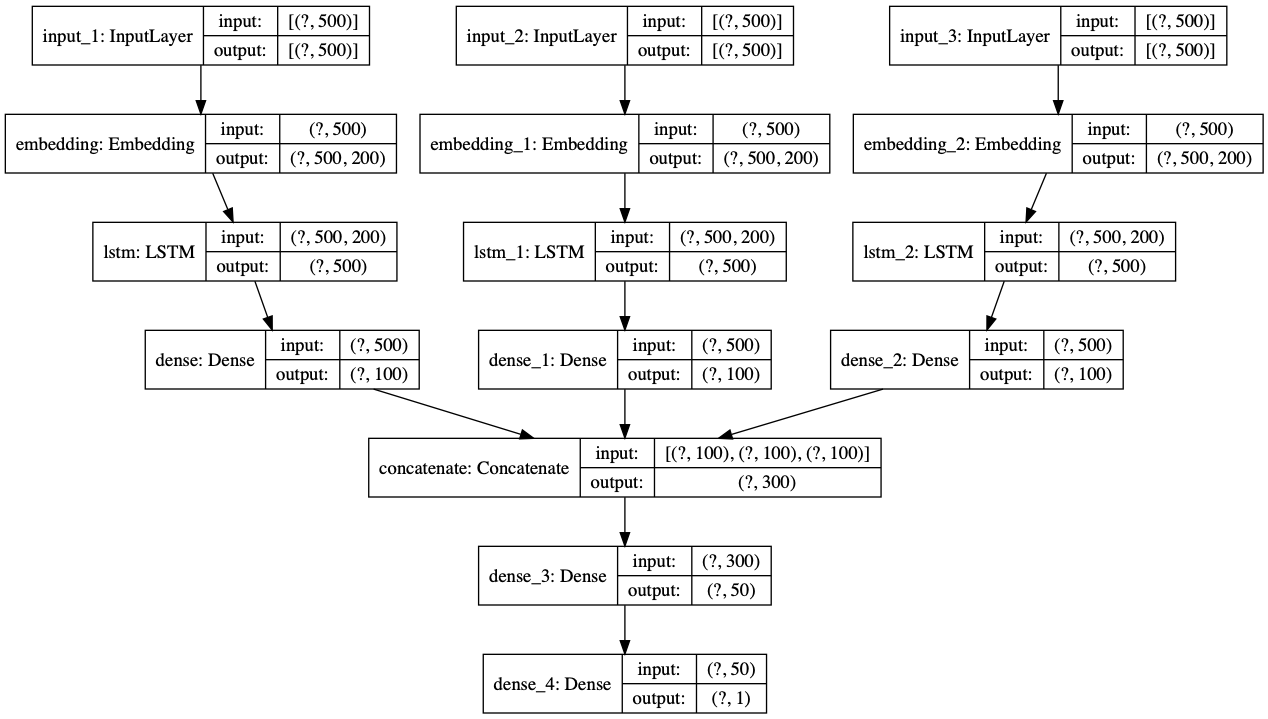

In [14]:
print(model.summary())
plot_model(model, 'multi_input_and_output_model.png', show_shapes=True)

In [15]:
history = model.fit({'input_1': input_1_data, 'input_2': input_2_data, 'input_3': input_3_data}, y_train, validation_split = 0.1, epochs=4, batch_size=128)

Train on 2135 samples, validate on 238 samples
Epoch 1/4
2135/2135 [==============================] - 300s 141ms/sample - loss: 0.0979 - root_mean_squared_error: 0.3129 - val_loss: 0.0904 - val_root_mean_squared_error: 0.3007
Epoch 2/4
2135/2135 [==============================] - 273s 128ms/sample - loss: 0.0780 - root_mean_squared_error: 0.2793 - val_loss: 0.0892 - val_root_mean_squared_error: 0.2987
Epoch 3/4
2135/2135 [==============================] - 269s 126ms/sample - loss: 0.0752 - root_mean_squared_error: 0.2741 - val_loss: 0.0917 - val_root_mean_squared_error: 0.3028
Epoch 4/4
2135/2135 [==============================] - 269s 126ms/sample - loss: 0.0714 - root_mean_squared_error: 0.2673 - val_loss: 0.0891 - val_root_mean_squared_error: 0.2985


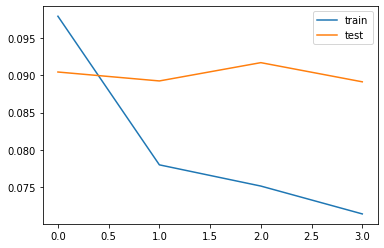

In [16]:
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test') 
pyplot.legend()
pyplot.show()

In [17]:
predictions = model.predict([val_input_1_data, val_input_2_data, val_input_3_data])
mse = tf.keras.losses.MeanSquaredError()
loss = mse(y_val, predictions)
print('Loss on validation set is %s' % loss.numpy())

Loss on validation set is 0.084047124


No handles with labels found to put in legend.


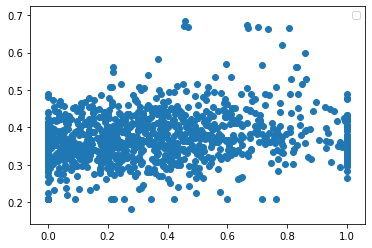

In [18]:
pyplot.scatter(y_val, predictions)
pyplot.legend()
pyplot.show()

In [19]:
# More fine grained accuracy calculations
huge_score = np.squeeze(np.argwhere(y_val > 0.7))
print('Data points with score more than 0.7 %s:' % len(huge_score))
val_data = x_val[huge_score,:]
y_true = y_val[huge_score]
predictions = model.predict([val_data[:,0,:], val_data[:,1,:], val_data[:,2,:]])
loss = mse(y_true, predictions)
print('Loss on validation set is %s' % loss.numpy())

Data points with score more than 0.7 153:
Loss on validation set is 0.25488544


In [20]:
# More fine grained accuracy calculations
huge_score = np.squeeze(np.argwhere(y_val < 0.3))
print('Data points with score less than 0.3 %s:' % len(huge_score))
val_data = x_val[huge_score,:]
y_true = y_val[huge_score]
predictions = model.predict([val_data[:,0,:], val_data[:,1,:], val_data[:,2,:]])
loss = mse(y_true, predictions)
print('Loss on validation set is %s' % loss.numpy())

Data points with score less than 0.3 466:
Loss on validation set is 0.06600395


In [21]:
# More fine grained accuracy calculations
huge_score = np.squeeze(np.argwhere((y_val > 0.3) & (y_val < 0.7)))
print('Data points with score greater than 0.3 and less than 0.7 %s:' % len(huge_score))
val_data = x_val[huge_score,:]
y_true = y_val[huge_score]
predictions = model.predict([val_data[:,0,:], val_data[:,1,:], val_data[:,2,:]])
loss = mse(y_true, predictions)
print('Loss on validation set is %s' % loss.numpy())

Data points with score greater than 0.3 and less than 0.7 397:
Loss on validation set is 0.023540732
